# Problem Set 6

Ari Boyarsky

aboyarsky@uchicago.edu

In [182]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from scipy.optimize import basinhopping
from sklearn.ensemble import BaggingRegressor
import graphviz
from sklearn.ensemble import RandomForestRegressor

In [183]:
dta = pd.read_csv("biden.csv")

a. Split the data into a training set (70%) and a test set (30%). Be sure to
set your seed prior to this part of your code to guarantee reproducibility
of results. Use recursive binary splitting to fit a decision tree to the training
data, with biden as the response variable and the other variables as
predictors. Plot the tree and interpret the results. What is the test MSE?

In [184]:
y = dta.biden.values
X = dta[['female', 'age', 'dem', 'rep', 'educ']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [185]:
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

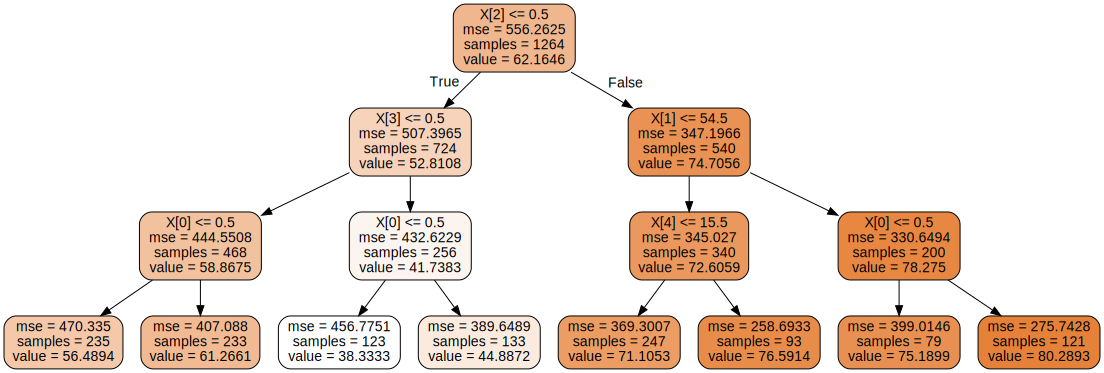

In [186]:
tree_viz = export_graphviz(
    tree,
    out_file=None,
    rounded=True,
    filled=True
)

graph = graphviz.Source(tree_viz)
graph.render('tree_viz')
graph

In [187]:
y_pred = tree.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print('MSE=', MSE)

MSE= 396.193714632


The first split occurs on democrat or republican, the second split on age or republican depending on the result in democrats. Then on age and gender. Demcorats tend to like biden more, where depending on age, education, and gender the value shifts. The highest rating of 100 comes a 3 person sample of people who are democrats, younger than 54.5 and recieved 4.5yrs of school. Overall females and democrats tend to like biden more.

(b) Leave the control options for tree() at their default values. Now fit another
tree to the training data with the following control options: tree(control
= tree.control(nobs = # number of rows in the training set, mindev = 0))
Use cross-validation to determine the optimal level of tree complexity, plot
the optimal tree, and interpret the results. Does pruning the tree improve
the test MSE?


In [188]:
def return_tree_mse(params):
    depth = params[0]
    tree = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=5)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    return MSE

In [189]:
MSEs = []
for i in range(200):
    params = np.array([i+1])
    MSEs.append(return_tree_mse(params))
print("Minimimum MSE: ", min(MSEs))
print("Optimal Depth: ", MSEs.index(min(MSEs))+1)


Minimimum MSE:  396.193714632
Optimal Depth:  3


Intrestingly enough, this is exactly the same as tree we built above and thus the interpretation will stay the same. This tree has a minimized MSE, and so pruning does improve MSE. We display it again below:

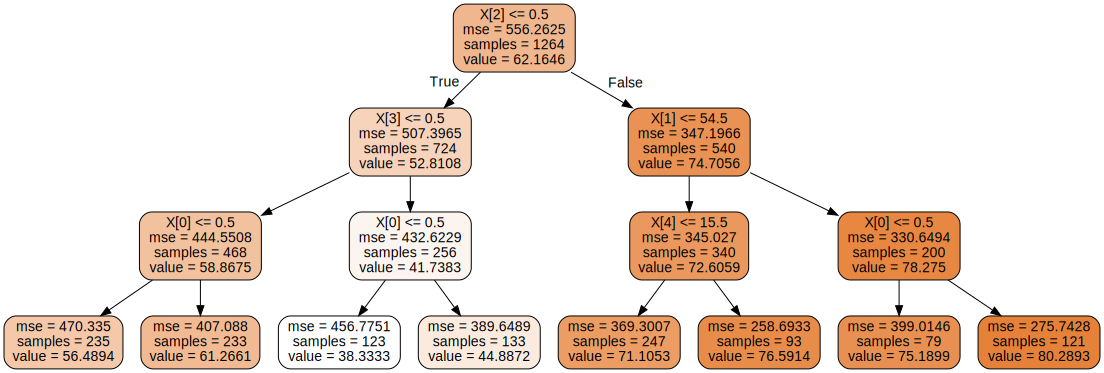

In [190]:
tree_viz = export_graphviz(
    tree,
    out_file=None,
    rounded=True,
    filled=True
)

graph = graphviz.Source(tree_viz)
graph.render('tree_viz')
graph

c. Use the bagging approach to estimate a tree to create a model for predicting
biden. What test MSE do you obtain? Obtain variable importance
measures and interpret the results.

In [191]:
tree_bagging = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100, max_samples=100, bootstrap=True, oob_score=True, random_state=15)
tree_bagging.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=15, verbose=0, warm_start=False)

In [192]:
tree_bagging.score(X, y)
y_pred = tree_bagging.oob_prediction_
MSE = mean_squared_error(y, y_pred)
print('MSE=', MSE)

MSE= 406.345462433


In [193]:
features = ['female', 'age', 'dem', 'rep', 'educ']
imp = np.mean([tree.feature_importances_ for tree in tree_bagging.estimators_], axis=0)
index = np.argsort(imp)[::-1]
for i in range(len(features)):
    print(features[i], ": ", imp[index[i]])


female :  0.442356087549
age :  0.200938790837
dem :  0.190292426493
rep :  0.106522219916
educ :  0.059890475205


Thus, gender is the most important variable in the model. 

(d) Use the random forest approach to estimate a tree to create a model for
predicting biden. Do this for m = 1, m = 2, and m = 3 (the number of
variables). What test MSE do you obtain in each case? Obtain variable
importance measures and interpret the results. Describe the effect of m,
the number of variables considered at each split, on the error rate obtained.


In [194]:
def get_importances(features, t):
    imp = np.mean([tree.feature_importances_ for tree in t.estimators_], axis=0)
    index = np.argsort(imp)[::-1]
    for i in range(len(features)):
        print(features[i], ": ", imp[index[i]])

In [195]:
forest = RandomForestRegressor(max_features=1, n_estimators=53, bootstrap=True,
                                  oob_score=True, random_state=15)
forest.fit(X, y)

forest.score(X, y)
y_pred = forest.oob_prediction_
MSE = mean_squared_error(y, y_pred)
print('M=1, MSE=', MSE)
get_importances(features, forest)

M=1, MSE= 533.908884112
female :  0.511547606575
age :  0.169752383781
dem :  0.148597579263
rep :  0.147259426581
educ :  0.0228430038004


In [196]:
forest = RandomForestRegressor(max_features=2, n_estimators=53, bootstrap=True,
                                  oob_score=True, random_state=15)
forest.fit(X, y)

forest.score(X, y)
y_pred = forest.oob_prediction_
MSE = mean_squared_error(y, y_pred)
print('M=2, MSE=', MSE)
get_importances(features, forest)

M=2, MSE= 535.302921272
female :  0.506245666812
age :  0.167429337266
dem :  0.154119771449
rep :  0.149425637463
educ :  0.0227795870096


In [197]:
forest = RandomForestRegressor(max_features=3, n_estimators=53, bootstrap=True,
                                  oob_score=True, random_state=15)
forest.fit(X, y)

forest.score(X, y)
y_pred = forest.oob_prediction_
MSE = mean_squared_error(y, y_pred)
print('M=3, MSE=', MSE)
get_importances(features, forest)

M=3, MSE= 534.661772163
female :  0.490997209509
age :  0.196353900874
dem :  0.15919425835
rep :  0.125669507814
educ :  0.0277851234523


Regardless of max features female continues to be the most important variable. Indeed the ordering is the same for each m and in fact the importnce levels are somewhat simmilar. The ordering is female, age, dem, rep, educ.